<a href="https://colab.research.google.com/github/DucBox/Finger-Classification/blob/main/Train_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikeras

In [1]:
import joblib
import pickle
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import BatchNormalization
from keras.initializers import glorot_uniform
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
# from scikeras.wrappers import KerasClassifier
from keras import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from keras.regularizers import l2
from keras.initializers import HeNormal
from tensorflow.keras.utils import to_categorical

In [2]:
df = pd.read_pickle("/content/drive/MyDrive/FingerClassification/Model/Hand Left-Right/data.pkl")

In [ ]:
#Resize with OpenCV dùng bilinear interpolation
import cv2
import numpy as np

def resize_blob_with_opencv(blob):
    # Chuyển đổi blob thành mảng NumPy nếu chưa phải
    blob_array = blob

    blob_array = blob_array.astype(np.float64)

    # Sử dụng cv2.resize để thay đổi kích thước mảng về 8x8 với bilinear interpolation
    resized_blob = cv2.resize(blob_array, (8, 8), interpolation=cv2.INTER_LINEAR)

    return resized_blob

df['Resized_Blobs'] = df['Blobs'].apply(resize_blob_with_opencv)


In [3]:
# Khởi tạo MinMaxScaler
scaler = MinMaxScaler()

# Lựa chọn các cột bạn muốn chuẩn hóa
columns_to_scale = ['Area', 'Angle', 'Major_Axis', 'Minor_Axis']

# Áp dụng Min-Max scaling cho các cột đã chọn
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
len(df)

95571

In [7]:
df_test.Participant.unique()

array([17, 18, 19, 20])

In [ ]:
len(df_test)

85858

In [6]:
# Mã hóa nhãn từ 'Right' và 'Left' sang 0 và 1
# le = LabelEncoder()
# df['Finger_Category'] = le.fit_transform(df['Finger_Category'])  # Right=1, Left=0
# df['Finger_Category'] = df['Finger'].apply(lambda x: 'Thumb' if x == 0 else 'Others')

# Tạo một cột mới dựa trên cột 'Finger'
df['Finger_Categorys'] = df['Finger'].replace({'little': 'Others', 'ring': 'Others', 'index': 'Others', 'middle': 'Others', 'thumb': 'Thumb'})

# Tiếp tục với việc mã hóa nhãn
le = LabelEncoder()
df['Finger_Category'] = le.fit_transform(df['Finger_Categorys'])

# Phân chia người tham gia
# Đặt những người tham gia vào tập kiểm tra
split_factor = 0.8
ptcp_train = df.Participant.unique()[:math.floor(len(df.Participant.unique())*split_factor)]
ptcp_test = df.Participant.unique()[math.floor(len(df.Participant.unique())*split_factor):]
df_train = df[df.Participant.isin(ptcp_train)].copy(deep=True)
df_test = df[df.Participant.isin(ptcp_test)].copy(deep=True)

X_train = np.stack(df_train[['New', 'Area']].values)
X_test = np.stack(df_test[['New', 'Area']].values)

X_train_features = np.array([sample[0] for sample in X_train])
X_train_area = np.array([sample[1] for sample in X_train])
# X_train_angle = np.array([sample[2] for sample in X_train])
# X_train_minor = np.array([sample[3] for sample in X_train])
# X_train_major = np.array([sample[4] for sample in X_train])

X_test_features = np.array([sample[0] for sample in X_test])
X_test_area = np.array([sample[1] for sample in X_test])
# X_test_angle = np.array([sample[2] for sample in X_test])
# X_test_minor = np.array([sample[3] for sample in X_test])
# X_test_major = np.array([sample[4] for sample in X_test])

y_train = df_train['Finger_Category'].values
y_test = df_test['Finger_Category'].values
# Chuyển đổi y_train và y_test sang giá trị số nguyên
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Chuyển đổi nhãn sang one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [ ]:
df_test.Participant.unique()

array([17, 18, 19, 20])

In [ ]:
len(df_test)

85858

In [ ]:
df_test.head()

In [4]:
df = df.sort_values(by='Timestamp', ascending=True)

In [ ]:
# In ra kích thước và kiểu dữ liệu của 5 blobs đầu tiên
for i, blob in enumerate(df['Resized_Blobs'][:5]):
    blob_array = np.array(blob)
    print(f"HOG_Vector {i}: shape = {blob_array.shape}, dtype = {blob_array.dtype}")


HOG_Vector 0: shape = (8, 8), dtype = float64
HOG_Vector 1: shape = (8, 8), dtype = float64
HOG_Vector 2: shape = (8, 8), dtype = float64
HOG_Vector 3: shape = (8, 8), dtype = float64
HOG_Vector 4: shape = (8, 8), dtype = float64


In [ ]:
df.head()

In [ ]:
# Thống kê kích thước và số lượng tương ứng
from collections import OrderedDict

size_counts = {}

for blob in df['BlobImage']:
    size = blob.shape  # Lấy kích thước của mảng
    if size in size_counts:
        size_counts[size] += 1
    else:
        size_counts[size] = 1

size_counts

sorted_size_counts = OrderedDict(sorted(size_counts.items(), key=lambda x: x[0]))

sorted_size_counts

OrderedDict([((12, 12), 95565),
             ((13, 14), 1),
             ((16, 15), 1),
             ((17, 15), 2),
             ((18, 15), 1),
             ((21, 15), 1)])

In [ ]:
# Tạo một mảng 2 chiều từ list các vectors HOG
X = np.stack(df['Resized_Blobs'].values)

# Khởi tạo
min_max_scaler = MinMaxScaler()

# Fit và transform
X_min_max_scaled = min_max_scaler.fit_transform(X)

# Thêm dữ liệu đã được chuẩn hóa vào DataFrame dưới dạng một cột mới
df['New'] = list(X_min_max_scaled)

In [5]:
# Bước 1: Làm phẳng mỗi mảng 2 chiều và tạo mảng 2 chiều cho việc scale
X_flattened = np.array([blob.flatten() for blob in df['Resized_Blobs'].values])
# Khởi tạo MinMaxScaler
min_max_scaler = MinMaxScaler()
# Bước 2: Fit và transform dữ liệu
X_min_max_scaled = min_max_scaler.fit_transform(X_flattened)

# Bước 3: Thêm dữ liệu đã được chuẩn hóa vào DataFrame
df['New'] = list(X_min_max_scaled)

In [ ]:
df.head()

In [ ]:
# Mã hóa nhãn từ 'Right' và 'Left' sang 0 và 1
le = LabelEncoder()
df['Handedness'] = le.fit_transform(df['Handedness'])  # Right=1, Left=0
# In mối tương quan giữa nhãn gốc và nhãn số nguyên
for label in zip(le.classes_, range(len(le.classes_))):
    print(f"Nhãn gốc '{label[0]}' được mã hóa thành: {label[1]}")

Nhãn gốc '0' được mã hóa thành: 0
Nhãn gốc '1' được mã hóa thành: 1


In [ ]:
X.shape, y.shape

((95571, 64), (95571,))

In [ ]:
# Phân chia người tham gia
split_factor = 0.8
ptcp_train = df.Participant.unique()[:math.floor(len(df.Participant.unique())*split_factor)]
ptcp_test = df.Participant.unique()[math.floor(len(df.Participant.unique())*split_factor):]
df_train = df[df.Participant.isin(ptcp_train)].copy(deep=True)
df_test = df[df.Participant.isin(ptcp_test)].copy(deep=True)

# Tạo dữ liệu huấn luyện từ DataFrame
X_train_new = np.stack(df_train['New'].values)
X_train_area = np.stack(df_train['Area'].values)
y_train = df_train['Handedness'].values

# Tạo dữ liệu kiểm tra từ DataFrame
X_test_new = np.stack(df_test['New'].values)
X_test_area = np.stack(df_test['Area'].values)
y_test = df_test['Handedness'].values



In [ ]:
df_test['Participant'].unique()

array([17, 18, 19, 20])

In [ ]:
df_train['Participant'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [ ]:
X_train[X_train < 0] = 0
X_test[X_test < 0] = 0

In [ ]:
X_train = X_train.astype('float64') / 268
X_test = X_test.astype('float64') / 268

In [ ]:
# Chuyển đổi y_train và y_test sang giá trị số nguyên
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Chuyển đổi nhãn sang one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Kiểm tra kích thước của các tập sau khi chuyển đổi
print("Kích thước của y_train sau khi chuyển đổi:", y_train_one_hot.shape)
print("Kích thước của y_test sau khi chuyển đổi:", y_test_one_hot.shape)

Kích thước của y_train sau khi chuyển đổi: (78268, 2)
Kích thước của y_test sau khi chuyển đổi: (17295, 2)


In [ ]:
# Kiểm tra kích thước của các tập
X_train.shape, y_train_one_hot.shape, X_test.shape, y_test_one_hot.shape

((78268, 5), (78268, 2), (17295, 5), (17295, 2))

In [ ]:
X_train = np.column_stack((X_train_new, X_train_area))
X_test = np.column_stack((X_test_new, X_test_area))

In [ ]:
print(df["Handedness"].unique)
for label in zip(le.classes_, range(len(le.classes_))):
    print(f"Nhãn gốc '{label[0]}' được mã hóa thành: {label[1]}")

In [ ]:
# Kiểm tra xem có giá trị NaN trong DataFrame không
nan_values = df.isna().sum()
print(nan_values)

In [ ]:
print(len(df))
feature_column = "Handedness"
num_classes = len(df[feature_column].unique())
print(num_classes)

95571
2


In [ ]:
df.head()

In [ ]:

model = Sequential([
    Dense(128, input_shape=(65,)),
    BatchNormalization(),
    Activation('relu'),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dense(16),
    BatchNormalization(),
    Activation('relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.BinaryAccuracy(name='accuracy')])
model.summary()


In [11]:
from keras.layers import Input, Concatenate
from keras.models import Model

# Định nghĩa các kích thước của các đặc trưng
input_shape_new = (64,)
input_shape_area = (1,)
# input_shape_angle = (1,)
# input_shape_minor = (1,)
# input_shape_major = (1,)

# Tạo các lớp đầu vào cho mỗi đặc trưng
input_new = Input(shape=input_shape_new, name='input_new')
input_area = Input(shape=input_shape_area, name='input_area')
# input_angle = Input(shape=input_shape_angle, name='input_angle')
# input_minor = Input(shape=input_shape_minor, name='input_minor')
# input_major = Input(shape=input_shape_major, name='input_major')

# Xây dựng mạng nơ-ron cho đặc trưng 'New'
x = Dense(128)(input_new)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Xây dựng mạng nơ-ron cho diện tích và góc của elip
y = Dense(128)(input_area)
y = BatchNormalization()(y)
y = Activation('relu')(y)

# z = Dense(128)(input_angle)
# z = BatchNormalization()(z)
# z = Activation('relu')(z)

# a = Dense(128)(input_minor)
# a = BatchNormalization()(a)
# a = Activation('relu')(a)

# b = Dense(128)(input_major)
# b = BatchNormalization()(b)
# b = Activation('relu')(b)


# Hợp nhất các đặc trưng
merged = Concatenate()([x,y])

# Tiếp tục xây dựng mạng nơ-ron
merged = Dense(64)(merged)
merged = BatchNormalization()(merged)
merged = Activation('relu')(merged)

merged = Dense(32)(merged)
merged = BatchNormalization()(merged)
merged = Activation('relu')(merged)

merged = Dense(16)(merged)
merged = BatchNormalization()(merged)
merged = Activation('relu')(merged)
# Lớp đầu ra
output = Dense(2, activation='softmax')(merged)

# Xây dựng mô hình với các lớp đầu vào và đầu ra
model = Model(inputs=[input_new, input_area], outputs=output)

# Biên dịch mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.BinaryAccuracy(name='accuracy')])

# Hiển thị cấu trúc của mô hình
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_new (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 input_area (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense_12 (Dense)            (None, 128)                  8320      ['input_new[0][0]']           
                                                                                                  
 dense_13 (Dense)            (None, 128)                  256       ['input_area[0][0]']          
                                                                                            

In [12]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/FingerClassification/Model/Thumb others/model31.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 50, verbose=0)

history = model.fit([X_train_features, X_train_area], y_train_one_hot,
                    validation_data=([X_test_features,X_test_area], y_test_one_hot),
                    epochs=50, batch_size=16, callbacks=[checkpoint, early_stopping])

history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/FingerClassification/Model/Thumb others/history31.csv', index=False)


Epoch 1/50
23116/23116 [==============================] - 86s 4ms/step - loss: 0.4032 - accuracy: 0.8274 - val_loss: 0.4369 - val_accuracy: 0.8136
Epoch 2/50
23116/23116 [==============================] - 81s 4ms/step - loss: 0.3649 - accuracy: 0.8468 - val_loss: 0.4309 - val_accuracy: 0.8336
Epoch 3/50
23116/23116 [==============================] - 80s 3ms/step - loss: 0.3477 - accuracy: 0.8549 - val_loss: 0.3752 - val_accuracy: 0.8451
Epoch 4/50
23116/23116 [==============================] - 82s 4ms/step - loss: 0.3379 - accuracy: 0.8600 - val_loss: 0.3902 - val_accuracy: 0.8370
Epoch 5/50
23116/23116 [==============================] - 81s 3ms/step - loss: 0.3310 - accuracy: 0.8628 - val_loss: 0.3939 - val_accuracy: 0.8321
Epoch 6/50
23116/23116 [==============================] - 83s 4ms/step - loss: 0.3247 - accuracy: 0.8660 - val_loss: 0.3719 - val_accuracy: 0.8461
Epoch 7/50
23116/23116 [==============================] - 83s 4ms/step - loss: 0.3207 - accuracy: 0.8679 - val_loss: 0

In [ ]:
# Tìm giá trị nhỏ nhất trong tất cả các ma trận trong cột 'BlobImage'
min_value = df['Major_Axis'].min()
min_value

0.0

In [ ]:
df.Task.unique()

array(['DRAG', 'SCROLL', 'TAP'], dtype=object)

In [ ]:
#q  q q q q q qq  qq  qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq    from keras.models import load_model

# Tải mô hình tốt nhất đã lưu trước đó
best_model = load_model('/content/drive/MyDrive/FingerClassification/Model/Thumn/model2.h5')

# Đánh giá mô hình tốt nhất trên tập dữ liệu kiểm tra
loss, accuracy = best_model.evaluate([X_test_features, X_test_area], y_test_one_hot, verbose=0)

# In kết quả
print(f"Best model test loss: {loss}")
print(f"Best model test accuracy: {accuracy}")


Best model test loss: 0.22615738213062286
Best model test accuracy: 0.9098703861236572


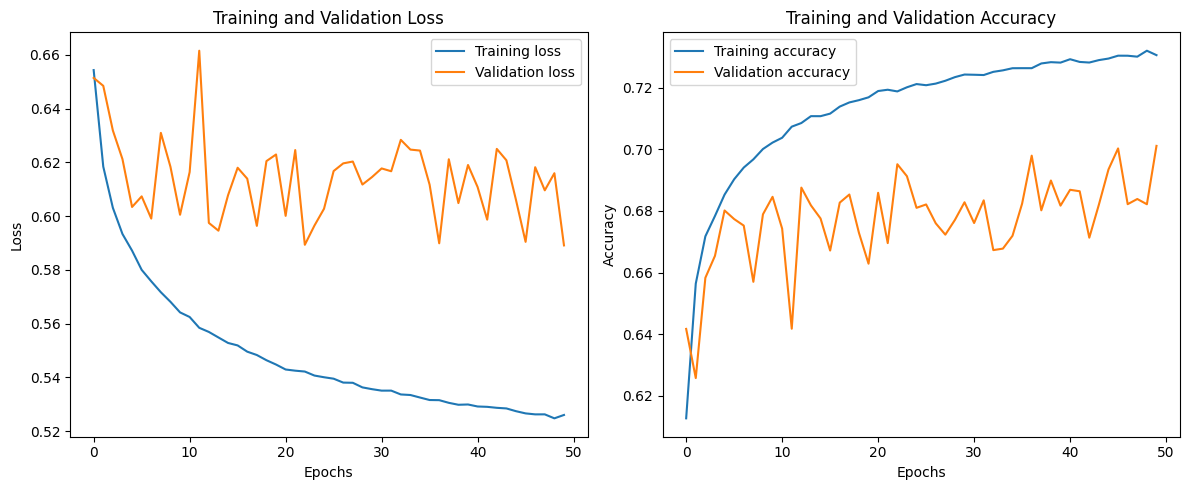

In [ ]:

# Tạo figure và axes với 1 hàng và 2 cột
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # figsize có thể điều chỉnh cho phù hợp

# Vẽ đồ thị loss trên trục thứ nhất
ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Vẽ đồ thị accuracy trên trục thứ hai
ax[1].plot(history.history['accuracy'], label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Hiển thị đồ thị
plt.tight_layout() # Điều chỉnh layout để không bị chồng chéo
plt.show()


GRID SEARCH

In [ ]:
print(model.get_params().keys())


dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])


In [ ]:
# Số lượng mẫu
n_samples = 100

# Tạo dữ liệu ngẫu nhiên
# Giả sử mỗi mẫu đầu vào là một vector có kích thước (900,)
X = np.random.randn(n_samples, 900)  # Dữ liệu đầu vào

# Tạo nhãn mẫu giả định là bài toán phân loại nhị phân (0 hoặc 1)
y = np.random.randint(0, 2, n_samples)  # Nhãn đầu ra

In [ ]:
# Định nghĩa lại hàm tạo model
def create_model(layers, activation, optimizer='adam'):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(Dense(nodes, input_dim=900))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam()
    elif optimizer == 'sgd':
        opt = SGD()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Khởi tạo model
model= KerasClassifier(model=create_model, verbose=0, activation='relu', layers=20)
layers = [
    [256],  # Một lớp với 256 node
    [128, 64],  # Hai lớp với số node giảm dần
    [256, 128, 64],  # Ba lớp với số node giảm dần
    [256, 128, 64, 32],  # Bốn lớp với số node giảm dần
    [512, 256, 128],  # Ba lớp với số node lớn hơn và giảm dần
    [128, 128],  # Hai lớp với số node đồng nhất
    [128, 128, 128],  # Ba lớp với số node đồng nhất
    [256, 128, 32],  # Ba lớp với sự giảm số node đáng kể ở lớp cuối
    [256, 256],  # Hai lớp với số node cao và đồng nhất
    [512],  # Một lớp với số node cao
    [256, 128, 128, 64],  # Bốn lớp, với hai lớp giữa có số node đồng nhất
    [512, 256, 256, 128, 128]  # Năm lớp, xen kẽ giữa số node đồng nhất và giảm dần
]

activations = ['relu']
# Tạo các phần của param_grid để thực hiện Grid Search từng phần một
# Ví dụ: chia 'layers' thành nhiều phần nhỏ hơn
layer_parts = [layers[:2], layers[2:4], layers[4:6], layers[6:8], layers[8:10], layers[10::12]]

for index, part in enumerate(layer_parts):
    param_grid_part = {
        'layers': part,
        'activation': activations,
        'optimizer': ['adam', 'sgd'],
        'batch_size': [32, 64],
        'epochs': [200]  # Giảm số lượng epochs để thí nghiệm
    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid_part, verbose=3)
    grid_result = grid.fit(X, y)  # X và y cần được định nghĩa trước

    # Lưu kết quả của từng phần
    file_name = f'/content/drive/MyDrive/FingerClassification/grid/grid_search_result_part_{index}.pkl'
    with open(file_name, 'wb') as file:
        pickle.dump(grid_result, file)

# Sau khi tất cả các phần hoàn thành, bạn có thể tải lại và tổng hợp kết quả
all_results = []
for i in range(len(layer_parts)):
    file_name = f'/content/drive/MyDrive/FingerClassification/grid/grid_search_result_part_{i}.pkl'
    with open(file_name, 'rb') as file:
        grid_result_part = pickle.load(file)
        all_results.append(grid_result_part)

# Tổng hợp và tìm ra kết quả tốt nhất từ tất cả các phần
best_score = -1
best_params = None
for result in all_results:
    if result.best_score_ > best_score:
        best_score = result.best_score_
        best_params = result.best_params_

print(f"Best overall score: {best_score}, Best params: {best_params}")

In [ ]:
# Tải lại và in kết quả tốt nhất từ mỗi file
for i in range(len(layer_parts)):
    file_name = f'/content/drive/MyDrive/FingerClassification/grid/grid_search_result_part_{i}.pkl'
    with open(file_name, 'rb') as file:
        grid_result_part = pickle.load(file)
        print(f"Best score for part {i}: {grid_result_part.best_score_}")
        print(f"Best params for part {i}: {grid_result_part.best_params_}\n")


Best score for part 0: 0.5000000000000001
Best params for part 0: {'activation': 'relu', 'batch_size': 32, 'epochs': 10, 'layers': [128, 64], 'optimizer': 'sgd'}

Best score for part 1: 0.56
Best params for part 1: {'activation': 'relu', 'batch_size': 32, 'epochs': 10, 'layers': [256, 128, 64, 32], 'optimizer': 'sgd'}

Best score for part 2: 0.5599999999999999
Best params for part 2: {'activation': 'relu', 'batch_size': 64, 'epochs': 10, 'layers': [512, 256, 128], 'optimizer': 'adam'}



USING CNN

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/FingerClassification/test/train'
